In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def rossler_integration(x_init, y_init, z_init, dt, N):
    """
    Simulates the Rossler attractor using numerical integration by Runge-Kuttar method.
    
    Parameters:
        x_init (float): initial x variables value (adimensional)
        y_init (float): initial x variables value (adimensional)
        z_init (float): initial z variables value (adimensional)
        dt (float): time step (in seconds)
        N (int): number of iteration of the simulation (adimensional)
        
    Returns:
        t (array): time values (in seconds)
        x (array): x variables (adimensional)
    """
    # Parameters of the Rossler attractor
    a = 0.15
    b = 0.20
    c = 10.0

    # Initialize time and variables arrays
    t_final = N * dt
    t = np.arange(0, t_final, dt)
    
    x = np.zeros_like(t) 
    y = np.zeros_like(t) 
    z = np.zeros_like(t) 
    
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init

    # Numerical integration using Runge-Kutta 4 method
    for i in range(1, len(t)):
        
        # k1
        k1_x = dt * (-y[i-1] - z[i-1])
        k1_y = dt * (x[i-1] + a * y[i-1])
        k1_z = dt * (b + z[i-1] * (x[i-1] - c))
        
        # k2
        k2_x = dt * (-(y[i-1] + k1_y/2) - (z[i-1] + k1_z/2))
        k2_y = dt * ((x[i-1] + k1_x/2) + a * (y[i-1] + k1_y/2))
        k2_z = dt * (b + (z[i-1] + k1_z/2) * ((x[i-1] + k1_x/2) - c))
        
        # k3
        k3_x = dt * (-(y[i-1] + k2_y/2) - (z[i-1] + k2_z/2))
        k3_y = dt * ((x[i-1] + k2_x/2) + a * (y[i-1] + k2_y/2))
        k3_z = dt * (b + (z[i-1] + k2_z/2) * ((x[i-1] + k2_x/2) - c))
        
        # k4
        k4_x = dt * (-(y[i-1] + k3_y) - (z[i-1] + k3_z))
        k4_y = dt * ((x[i-1] + k3_x) + a * (y[i-1] + k3_y))
        k4_z = dt * (b + (z[i-1] + k3_z) * ((x[i-1] + k3_x) - c))
        
        
        # Variables update
        x[i] = x[i-1] + 1/6 * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        y[i] = y[i-1] + 1/6 * (k1_y + 2*k2_y + 2*k3_y + k4_y)
        z[i] = z[i-1] + 1/6 * (k1_z + 2*k2_z + 2*k3_z + k4_y) #ERRORE



    return t, x, y, z

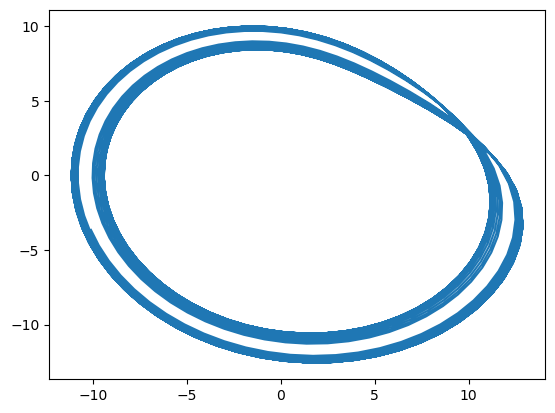

In [7]:
N_tot = 2100
dt = 0.1
t_tot, x, y, z = rossler_integration(7, -2, 2, dt, N_tot)

transient = 100
N = N_tot - transient
t = t_tot[: N_tot - transient]
x = x[transient:]
y = y[transient:]
z = z[transient:]

plt.plot(x, y)
plt.show()

### attractor reconstruction

the implemented code below holds for integer value of J (the lag). The attractor dynamics is reconstructed using 
the method of delays

In [8]:
m = 3
J = 8
M = N - (m - 1) * J

In [9]:
X = np.zeros((M, m))

In [10]:
for i in range(M):
    for k in range(m):
        X[i][k] = x[i + J * k]
    

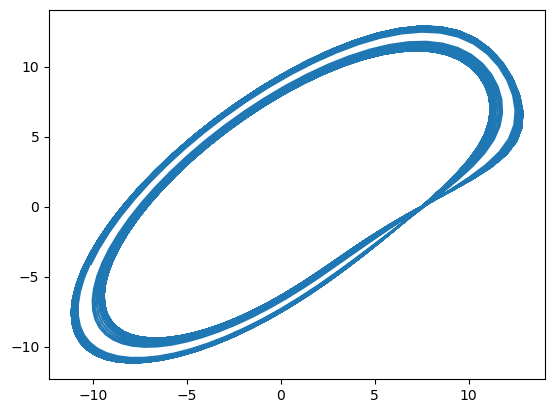

In [11]:
plt.plot(X.T[0], X.T[1])
plt.show()

### computation of mean period of the time serie

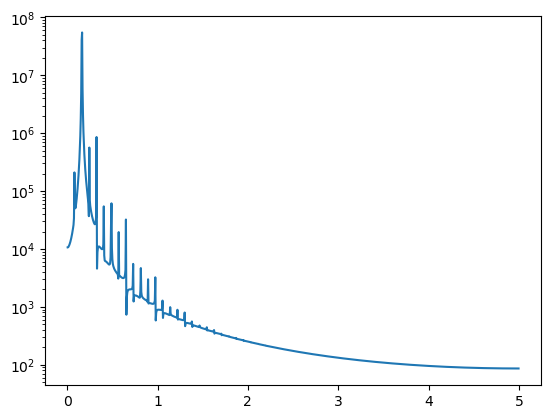

In [13]:
ps = np.abs(np.fft.fft(x))**2
dt = 0.1
freqs = np.fft.fftfreq(N, dt)
plt.semilogy(freqs[1:N//2], ps[1:N//2])
plt.show()

In [17]:
mean_f = np.average(freqs[1:N//2], weights=ps[1:N//2])
mean_T = 1/mean_f
print(mean_f, mean_T)

0.1697389001368067 5.891401435934938


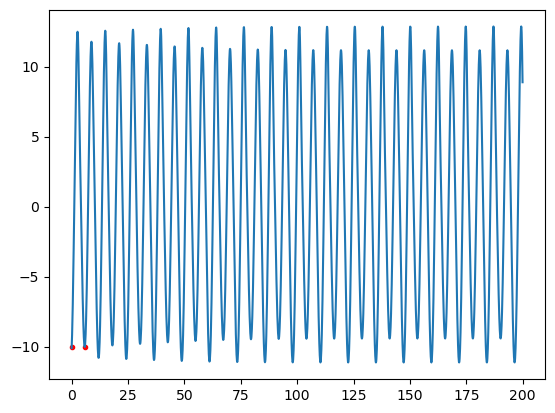

In [18]:
plt.plot(t,x)
plt.scatter([0, mean_T], [-10, -10], marker='.', color='r')
plt.show()

ha senso che i periodi medi che ottengo siano maggiori del tempo massimo campionato? intuitivamente mi verrebbe da dire di no... 
comunque questo check mi è servito per notare che c'era un errore nel codice e adesso esce fuori un periodo medio del segnale
ragionevole avendo come riferimento la serie temporale


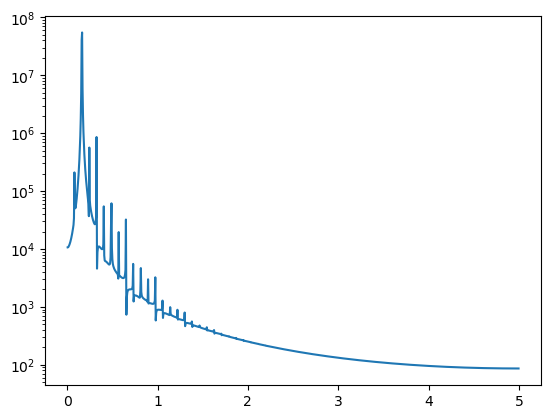

In [63]:
# la stessa cosa fatta con numpy la si può fare con scipy
from scipy.fft import fft, fftfreq, fftshift

y = np.copy(x)
yf = fft(y)[1:N//2]
xf = fftfreq(N, dt)[1:N//2]

plt.semilogy(xf, np.abs(yf)**2)
plt.show()


### Find nearest neighbors applying the temporal constraint

In [19]:
%%time
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

Wall time: 2.12 s


array([[   0,  123,  246],
       [   1,  124,  247],
       [   2,  125,  248],
       ...,
       [1981, 1858, 1735],
       [1982, 1859, 1736],
       [1983, 1860, 1737]], dtype=int64)

In [68]:
# voglio fare il check che l'algoritmo precedente funzioni davvro
# ricalcolo il nearest neighbor per un punto generico dell'orbita ricostruita
ref_point = 100
min_d = 1000
count = ref_point
for r in range(M):
    d_ref = np.linalg.norm(X[ref_point] - X[r])
    if d_ref < min_d and r!=ref_point:
        min_d = d_ref
        count = r
np.abs(count-ref_point)
# da questo check sembrerebbe tutto corretto (viene sempre fuori 123)

123

In [20]:
# mi serve per verificare che nella prima colonna di indices sia ok...
for i in range(len(indices.T[0])):
    if indices.T[0][i] != i:
        print('hello')
print('fine check')

fine check


In [21]:
# check per il constraint temporale dei primi vicini
for i in range(len(indices.T[0])):
    if np.abs(indices.T[0][i] - indices.T[1][i]) <= mean_T:
        print('hello')
print('fine check')
# a quanto pare non ci sono mai problemi con il constraint temporale

fine check


In [25]:
# questo è un risultato molto strano...
for i in range(len(indices.T[0])):
    if np.abs(indices.T[0][i] - indices.T[1][i]) != 123:
        print('hello')
print('fine check')      


fine check


In [51]:
# calcoliamo l'evoluzione della distanza tra un punto j_ref e il suo nearest neighbor k_ref
i_max = 1000
j_ref = 500
k_ref = indices.T[1][j_ref]
d_j = np.zeros(i_max + 1)

for r in range(i_max + 1):
    d_j[r] = np.linalg.norm(X[j_ref + r] - X[k_ref + r])

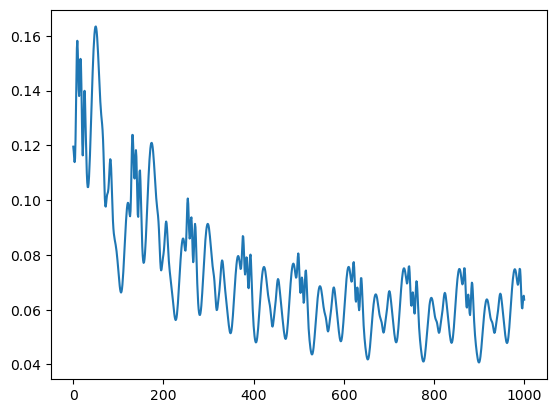

In [52]:
plt.plot(np.linspace(0, i_max, i_max + 1), d_j)
plt.show()
# aumentando la j_ref si osserva prima la saturazione di d_j (considerando il valore medio)

il plot osservato non è assolutamente quello che mi aspettavo di vedere per un sistema caotico; in effetti se ci pensi la mia
serie temporale ad una prima osservazione sembra qualcosa di quasi periodico... mi sa che devo cambiare condizioni iniziali 
per ottenere una serie temporale diverse da quella attuale